In [ ]:
!pip install equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [ ]:
! wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
! wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz

--2024-04-01 18:31:42--  https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mroberto166/CAMLab-DLSCTutorials/main/antiderivative_aligned_train.npz [following]
--2024-04-01 18:31:43--  https://raw.githubusercontent.com/mroberto166/CAMLab-DLSCTutorials/main/antiderivative_aligned_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241573 (236K) [application/octet-stream]
Saving to: ‘antiderivative_aligned_train.npz’

antiderivative_alig 100%[===================>] 235.91K  --.-KB/s    in 0.03s   

2024-

In [ ]:
dataset_train = jnp.load("antiderivative_aligned_train.npz", allow_pickle = True)
branch_inputs_train = dataset_train["X"][0]
trunk_inputs_train = dataset_train["X"][1]
outputs_train = dataset_train["y"]

In [ ]:
branch_inputs_train.shape, trunk_inputs_train.shape, outputs_train.shape

((150, 100), (100, 1), (150, 100))

In [ ]:
dataset_test = jnp.load("antiderivative_aligned_test.npz", allow_pickle = True)
branch_inputs_test = dataset_test["X"][0]
trunk_inputs_test = dataset_test["X"][1]
outputs_test = dataset_test["y"]

In [ ]:
branch_inputs_test.shape, trunk_inputs_test.shape, outputs_test.shape

((1000, 100), (100, 1), (1000, 100))

In [ ]:
trunk_inputs_train

array([[0.        ],
       [0.01010101],
       [0.02020202],
       [0.03030303],
       [0.04040404],
       [0.05050505],
       [0.06060606],
       [0.07070707],
       [0.08080808],
       [0.09090909],
       [0.1010101 ],
       [0.11111111],
       [0.12121212],
       [0.13131313],
       [0.14141414],
       [0.15151515],
       [0.16161616],
       [0.17171717],
       [0.18181818],
       [0.19191919],
       [0.2020202 ],
       [0.21212121],
       [0.22222222],
       [0.23232323],
       [0.24242424],
       [0.25252525],
       [0.26262626],
       [0.27272727],
       [0.28282828],
       [0.29292929],
       [0.3030303 ],
       [0.31313131],
       [0.32323232],
       [0.33333333],
       [0.34343434],
       [0.35353535],
       [0.36363636],
       [0.37373737],
       [0.38383838],
       [0.39393939],
       [0.4040404 ],
       [0.41414141],
       [0.42424242],
       [0.43434343],
       [0.44444444],
       [0.45454545],
       [0.46464646],
       [0.474

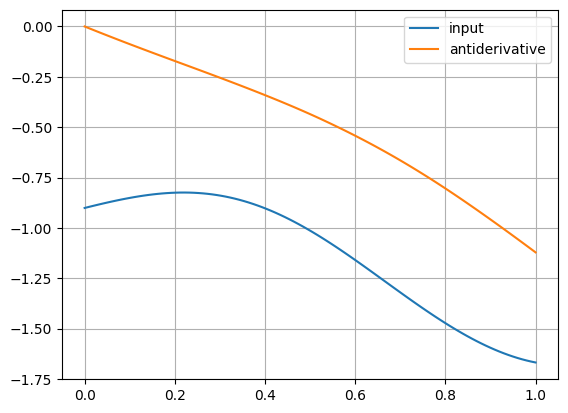

In [ ]:
# due to the the dataset being aligned, we can use the trunk inputs as a grid
plt.plot(
    trunk_inputs_train[:, 0],
    branch_inputs_train[0,:],
    label = "input",
)
plt.plot(
    trunk_inputs_train[:, 0],
    outputs_train[0,:],
    label = "antiderivative",
)
plt.legend()
plt.grid()

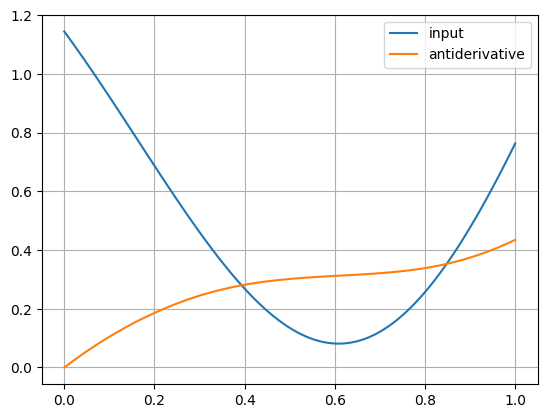

In [ ]:
# due to the the dataset being aligned, we can use the trunk inputs as a grid
plt.plot(
    trunk_inputs_train[:, 0],
    branch_inputs_train[2,:],
    label = "input",
)
plt.plot(
    trunk_inputs_train[:, 0],
    outputs_train[2,:],
    label = "antiderivative",
)
plt.legend()
plt.grid()

In [ ]:
class DeepONet1d(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self,
        in_size_branch,
        width_size,
        depth,
        interact_size,
        activation,
        *,
        key,
    ):
        """
        For simplicity, branch and trunk MLP are configured similarly
        """
        b_key, t_key = jr.split(key)
        self.branch_net = eqx.nn.MLP(
            in_size=in_size_branch,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            key=b_key,
        )
        self.trunk_net = eqx.nn.MLP(
            in_size=1,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            activation=activation,
            final_activation=activation,
            key=t_key,
        )
        self.bias = jnp.zeros((1,))

    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """
        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)
        inner_product = jnp.sum(branch_out * trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]

In [ ]:
antiderivative_operator = DeepONet1d(
    in_size_branch=100,
    width_size=40,
    depth=1,
    interact_size=40,
    activation=jax.nn.relu,
    key=jr.PRNGKey(0),
)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(
    eqx.filter(antiderivative_operator, eqx.is_array)
)

def loss_fn(model):
    # Full batch training

    # Vectorize over both the batches/samples and the query points
    predictions = jax.vmap(
        jax.vmap(
            model,
            in_axes=(None, 0),
        ),
        in_axes=(0, None)
    )(branch_inputs_train, trunk_inputs_train)

    mse = jnp.mean(jnp.square(predictions - outputs_train))
    return mse

@eqx.filter_jit
def update_fn(model, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

loss_history = []
for _ in tqdm(range(10_000)):
    antiderivative_operator, opt_state, loss = update_fn(
        antiderivative_operator, opt_state
    )
    loss_history.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

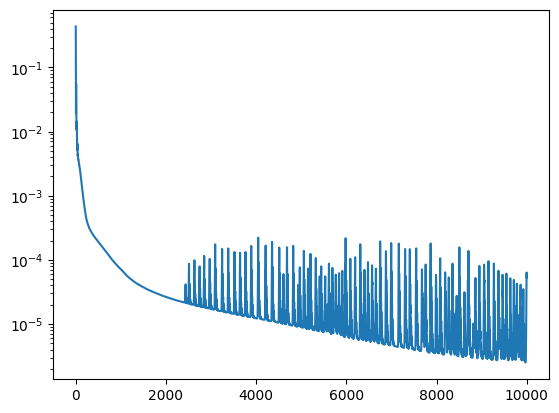

In [ ]:
plt.semilogy(loss_history)

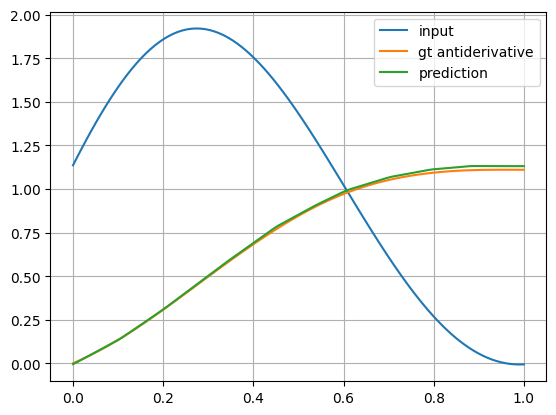

In [ ]:
plt.plot(
    trunk_inputs_test[:, 0],
    branch_inputs_test[0, :],
    label="input",
)
plt.plot(
    trunk_inputs_test[:, 0],
    outputs_test[0, :],
    label="gt antiderivative",
)
plt.plot(
    trunk_inputs_test[:, 0],
    jax.vmap(
        antiderivative_operator,
        in_axes=(None, 0)
    )(branch_inputs_test[0, :], trunk_inputs_test),
    label="prediction",
)
plt.legend()
plt.grid()


In [ ]:
predictions_test = jax.vmap(
    jax.vmap(
        antiderivative_operator,
        in_axes=(None, 0)
    ),
    in_axes=(0, None,)
)(branch_inputs_test, trunk_inputs_test)

In [ ]:
predictions_test.shape

(1000, 100)

In [ ]:
def normalized_l2_error(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm


In [ ]:
test_errors = jax.vmap(normalized_l2_error)(predictions_test, outputs_test)

In [ ]:
mean_test_error = jnp.mean(test_errors)
std_test_error = jnp.std(test_errors)

In [ ]:
mean_test_error, std_test_error

(Array(0.01788488, dtype=float32), Array(0.02149484, dtype=float32))